# =========================================================
# PolyEpi: Polygenic Phenotype with Higher-Order Epistasis Interactios
# =========================================================

# Path to the config file (Modify this before running the notebook.

In [1]:
#configFilePath='SampleData/config-small.json' # ~100 SNPs
#configFilePath='SampleData/config-large.json' # ~5,000 SNPs
#configFilePath='1000Genomes/config.json' # ~17,000 SNPs
configFilePath='SampleData/config-peps2.json'

# Initialisation

In [2]:
import sys
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import json
from collections import Counter
from random import random

from pprint import pprint
from pdbio.vcfdataframe import VcfDataFrame

import itertools

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from scipy import stats
import sklearn

TA = [1, .5, 1e-1, 1e-2, 1e-3, 1e-8, 1e-20]

# Read the config file

In [3]:
with open(configFilePath, 'r') as f:
    config = json.load(f)

In [4]:
shuffleSnps = config['shuffleSnps']
seed = config['seed']

np.random.seed(None if shuffleSnps else seed)

inputType = config['inputType']
dumpCSV = config['dumpCSV']

vcfInputPath = config['inputPrefix']+'.vcf'
csvInputPath = config['inputPrefix']+'.csv'

outputPrefix = config['outputPrefix']

pvalueThr = config['pvalueThr']
numTree = config['numTree']
numLoop = config['numLoop']

# Compute total numebr of variables and number of requierd SNPs to form the variables

In [5]:
numVariables = 0
numSnpsNeeded = 0
maxOrder = 0

for v in config['variables']:
    v['numSNPs'] = v['numVar'] * v['numSnpsInVar']
    numVariables += v['numVar']
    numSnpsNeeded += v['numSNPs']
    if v['numSnpsInVar']>maxOrder:
        maxOrder = v['numSnpsInVar']
    
config['numVariables'] = numVariables
config['numSnpsNeeded'] = numSnpsNeeded
config['maxOrder'] = maxOrder

# Print config data and write it in "outputPrefix.config.json"

In [6]:
print("========== Configuration >>>")
pprint(config)
print("============================")
with open(outputPrefix+'.config.json','w') as outfile:
    json.dump(config, outfile, indent=4, sort_keys=True)

========== Configuration >>>
{'dumpCSV': False,
 'inputPrefix': '1000Genomes/all-snps',
 'inputType': 'csv',
 'maxOrder': 5,
 'numLoop': 1,
 'numSnpsNeeded': 54,
 'numTree': 1000,
 'numVariables': 24,
 'outputPrefix': 'SampleData/PEPS2_54snps',
 'pvalueThr': 1.0,
 'seed': 1,
 'shuffleSnps': False,
 'variables': [{'numSNPs': 10, 'numSnpsInVar': 1, 'numVar': 10},
               {'numSNPs': 10, 'numSnpsInVar': 2, 'numVar': 5},
               {'numSNPs': 12, 'numSnpsInVar': 3, 'numVar': 4},
               {'numSNPs': 12, 'numSnpsInVar': 4, 'numVar': 3},
               {'numSNPs': 10, 'numSnpsInVar': 5, 'numVar': 2}]}


# Parse input genotype data from a VCF or CSV file
## If read from VCF file, the SNP id is set to CHROM:POS:REF:ALT

In [7]:
if inputType=='vcf':
    vcfdf = VcfDataFrame(path=vcfInputPath)
    df = vcfdf.df
    df['SNP'] = df['#CHROM'].astype(str) + ':' + df['POS'].astype(str) + ':' + df['REF'].astype(str) + ':' + df['ALT'].astype(str)
    df = df.set_index('SNP')
    snpData = df.iloc[:,9:].replace(['0/0','0/1','1/1'], [0,1,2])
    if dumpCSV:
        snpData.to_csv(csvInputPath)
elif inputType=='csv':
    snpData = pd.read_csv(csvInputPath)
    snpData = snpData.set_index('SNP')
else:
    print("Incorrect inputType (should be 'vcf' or 'csv')")
    exit()

In [8]:
snpData.iloc[:5,:5]

,HG00096,HG00097,HG00099,HG00100,HG00101
SNP,,,,,
1:15820:G:T,1,1,1,0,0
1:62777:A:T,1,1,0,1,1
1:63268:T:C,0,0,0,0,1
1:843405:A:G,1,1,0,0,2
1:1012483:G:T,0,2,2,2,2


# There should be enough SNPs in the input file to create all variables

In [9]:
print("Number of SNPs in the input file: ", snpData.shape[0])
print("Number of SNPs needed: ", numSnpsNeeded)

if snpData.shape[0] < numSnpsNeeded:
    print("There are not enough SNPs in the input file")
    exit(1)
else:
    print("There are enough SNPs in the input file")

Number of SNPs in the input file:  17373
Number of SNPs needed:  54
There are enough SNPs in the input file


# Suffle SNPs if asked in the config file.
## When SNPs are shuffled different set of SNPs used to form each variables each time

In [10]:
snpData = snpData.sample(frac=1)

# Transpose the genotype data and print number of snps and samples
## Also rename 0/0, 0/1 and 1/1 to R, H and A

In [11]:
snpData = snpData.T

In [12]:
df = snpData.replace([0,1,2],['R','H','A'])
numSamples = df.shape[0]
numSNPs = df.shape[1]
print("number of sample",numSamples)
print("number of snp",numSNPs)

number of sample 2504
number of snp 17373


# Form variables from SNPs
## A variable could be a SNPs or a set of Interactive SNPs
## First identify whcih SNPs belong to each variable and then form the variables
## Naming of variables: O3V4 is the 4th variable with 3-interactive SNPs
## Write Variables SNPs infor in "outputPrefix.varData.csv"

In [13]:
colNames = list() # to store variable names
for o,v in enumerate(config['variables']):
    for i in range(0,v['numVar']):
        colNames.append('O'+str(o+1)+'V'+str(i+1))

In [14]:
rowNames = ['order']
for o in range(maxOrder):
    rowNames.append('snp_'+str(o+1))

In [15]:
varData = pd.DataFrame(index=rowNames, columns=colNames)

In [16]:
idx = 0
for o,v in enumerate(config['variables']):
    for i in range(0,v['numVar']):
        name = 'O'+str(o+1)+'V'+str(i+1)
        varData.at['order',name] = str(o+1)
        for k in range(0,v['numSnpsInVar']):
            snp = 'snp_'+str(k+1)
            varData.at[snp,name]=df.columns[idx]
            idx += 1
varData = varData.fillna('---')

In [17]:
varData.to_csv(outputPrefix+'.varData.csv')

In [18]:
varData.iloc[:6,-5:]

,O4V1,O4V2,O4V3,O5V1,O5V2
order,4,4,4,5,5
snp_1,8:98902046:A:T,8:119176046:A:G,9:5346995:T:C,5:170173230:A:G,11:104044426:A:G
snp_2,22:45435937:G:A,15:65663810:T:A,12:130897844:A:C,12:118537903:G:A,7:108241091:T:C
snp_3,14:66111019:T:A,19:53973172:C:T,16:11034933:A:G,6:23664848:A:T,22:22558078:C:T
snp_4,4:155341410:T:C,8:104125489:G:A,8:135867935:T:A,19:54756118:A:G,13:80896094:C:T
snp_5,---,---,---,16:27122796:G:A,9:8385838:T:C


# Form Variable Genotype and write it to "outputPrefix.varGT.csv"
## For variables with more than one SNPs the genotype is the concatination of all SNPs involved
## For example RHA, ARH and AAR could be genotype value of a variable with 3 snps

In [19]:
varGT = df.iloc[:,-1:0].copy()

In [20]:
for o,v in enumerate(config['variables']):
    for i in range(0,v['numVar']):
        name = 'O'+str(o+1)+'V'+str(i+1)
        varGT[name] = ''
        for k in range(0,v['numSnpsInVar']):
            snp = 'snp_'+str(k+1)
            varGT[name] = varGT[name] + df[varData.loc[snp,name]]

In [21]:
varGT.to_csv(outputPrefix+'.varGT.csv')

In [22]:
varGT.iloc[:5,-5:]

SNP,O4V1,O4V2,O4V3,O5V1,O5V2
HG00096,RRRR,HAAH,HHHA,RHHAR,RHHAH
HG00097,RRRH,HAAR,HAHR,RHHHR,RRRHH
HG00099,ARHR,RAAR,RHHA,HRRAH,HARRR
HG00100,ARRH,RAHH,RAAH,HRHHR,HARHR
HG00101,ARRA,RHAH,RHAH,RRHHR,RRRAR


In [23]:
PEPS2_Input = varGT.T.values.tolist()

# PEPS2 Simulation

In [24]:
def assign(genotypes, case_freq):
    """Create a list representing Cases (1) and Controls (0)
​
    Assigns cases and controls to the samples (in order) such that all
    variables have a similar impact on the phenotype, and the case frequency is
    case_freq.
​
    :param genotypes: A list of lists, where the primary index is variable, and
        the secondary index is sample. Elements represent the value taken by
        that variable in that sample. the most common value doesn't contribute
        to the phenotype.
    :param case_freq: The desired frequency of the case in the population.
    :return: a list of the phenotypes of the samples
    """
    num_samples = len(genotypes[0])
    global_base_case = num_samples * (
        1 - (1-case_freq) ** (1 / len(genotypes))
    )
    variable_likelihoods = []
    for variable_values in genotypes:
        value_counts = Counter(variable_values)
        del value_counts[value_counts.most_common(1)[0][0]]  # remove most common genotype
        num_values = len(value_counts)
        variable_likelihoods.append({
            k: 1 - min(global_base_case / (num_values * v), 1)
            for k, v in value_counts.items()
        })
    sample_likelihoods = []
    for s_i in range(num_samples):
        control_prob = 1
        for v_i, variable in enumerate(genotypes):
            control_prob *= variable_likelihoods[v_i].get(variable[s_i], 1)
        sample_likelihoods.append((control_prob, s_i))
    sample_phenotypes = [0] * num_samples
    sample_likelihoods.sort()
    for _, s_i in sample_likelihoods[:int(case_freq * num_samples)]:
        sample_phenotypes[s_i] = 1
    return sample_phenotypes

In [25]:
PEPS2_Output = assign(PEPS2_Input,0.5)

In [26]:
varGT['lbl'] = PEPS2_Output

# Compute and plot chi2-pvalue (log10) of the variables for the random phenotype

,number of vars exceed the p-value
p-value,
1.000000e+00,24
5.000000e-01,24
1.000000e-01,23
1.000000e-02,21
1.000000e-03,21
1.000000e-08,11
1.000000e-20,4


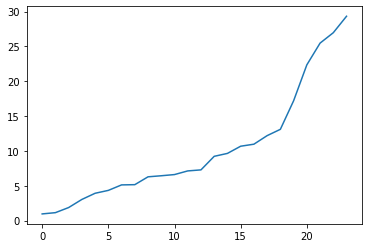

In [27]:
features = varGT.columns[:-1]
corrDict = dict()
for v in features:
    corrDict[v] = stats.chi2_contingency(pd.crosstab(varGT['lbl'],varGT[v]).values)[1]
a = np.asarray(list(corrDict.values()))
b = - np.log10(a)
plt.plot(np.sort(b))
nsat = list()
for t in TA:
    nsat.append([t, np.where(a<t)[0].shape[0]])
x = pd.DataFrame(nsat)
x.columns =['p-value', 'number of vars exceed the p-value']
x.set_index('p-value')

# Write Phenotype into a file outputPrefix.pheno.csv

In [28]:
phen = varGT[['lbl']].copy()
phen.index.name ='sample'
phen.to_csv(outputPrefix+'.pheno.csv')

In [29]:
phen.head()

SNP,lbl
sample,
HG00096,1
HG00097,1
HG00099,0
HG00100,1
HG00101,1


In [30]:
varData.to_csv(outputPrefix+'.varDataTruth.csv')

In [31]:
varData.iloc[:6,-5:]

,O4V1,O4V2,O4V3,O5V1,O5V2
order,4,4,4,5,5
snp_1,8:98902046:A:T,8:119176046:A:G,9:5346995:T:C,5:170173230:A:G,11:104044426:A:G
snp_2,22:45435937:G:A,15:65663810:T:A,12:130897844:A:C,12:118537903:G:A,7:108241091:T:C
snp_3,14:66111019:T:A,19:53973172:C:T,16:11034933:A:G,6:23664848:A:T,22:22558078:C:T
snp_4,4:155341410:T:C,8:104125489:G:A,8:135867935:T:A,19:54756118:A:G,13:80896094:C:T
snp_5,---,---,---,16:27122796:G:A,9:8385838:T:C


# Filter SNPs included in All and Truth Variables
## write the Truth SNP names in  "outputPrefix.TruthSNP.csv"

In [32]:
snps = np.unique(varData.replace(np.nan, '', regex=True).drop('order').values.ravel())[1:]
snpDataVar = snpData.loc[:, snpData.columns.isin(snps)].copy()

pd.DataFrame(snps).rename(columns={0:'v'}).to_csv(outputPrefix+'.TruthSNP.csv',index=False)

In [33]:
snpData

SNP,10:13163062:A:G,8:27617229:A:G,2:62739135:A:C,13:49041799:C:A,10:29278237:A:G,9:120258305:C:G,10:99360792:C:T,9:137716227:A:G,2:171082333:G:A,9:113165566:C:T,...,11:118025917:G:A,7:155923616:C:T,20:9440715:C:G,1:15154630:C:T,8:1789817:A:T,11:112340860:T:A,22:46354932:G:C,5:56883238:T:C,13:36734676:C:A,1:24206753:C:T
HG00096,0,2,1,0,1,1,1,2,2,1,...,1,0,1,0,1,1,1,2,0,2
HG00097,0,2,2,1,0,1,1,2,2,2,...,2,2,0,1,0,1,1,2,1,2
HG00099,1,2,2,1,0,0,1,2,1,1,...,0,1,1,1,0,1,0,2,0,2
HG00100,1,2,2,1,0,1,1,0,1,0,...,1,1,0,0,1,2,0,2,0,1
HG00101,1,2,2,1,2,2,1,1,1,0,...,1,1,1,0,1,0,1,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NA21137,0,2,2,1,2,1,1,1,1,1,...,1,0,1,1,0,1,0,0,2,2
NA21141,0,2,2,1,1,0,0,1,1,1,...,1,0,1,1,0,1,0,1,0,2
NA21142,1,2,2,2,1,1,0,2,1,1,...,2,2,1,1,0,1,1,1,1,2
NA21143,1,2,2,1,0,1,0,2,1,2,...,1,1,1,0,2,1,0,1,0,1


In [34]:
num_truth_snp = snpDataVar.shape[1]
print("Number of SNPs used to form Variables: ",num_truth_snp)

Number of SNPs used to form Variables:  54


In [35]:
snpDataVar.iloc[:5,-5:]

SNP,11:104044426:A:G,7:108241091:T:C,22:22558078:C:T,13:80896094:C:T,9:8385838:T:C
HG00096,0,1,1,2,1
HG00097,0,0,0,1,1
HG00099,1,2,0,0,0
HG00100,1,2,0,1,0
HG00101,0,0,0,2,0


# Add Phenotype to SNP Data

In [36]:
snpDataVar.loc[:, 'lbl'] = varGT['lbl']
snpData.loc[:, 'lbl'] = varGT['lbl']

# Compute and plot chi2-pvalue (log10) of the variables for the random phenotype

,number of SNPs exceed the p-value
p-value,
1.000000e+00,54
5.000000e-01,53
1.000000e-01,51
1.000000e-02,41
1.000000e-03,34
1.000000e-08,12
1.000000e-20,4


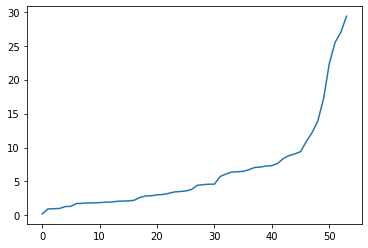

In [37]:
features = snpDataVar.columns[:-1]
corrDict = dict()
for v in features:
    corrDict[v] = stats.chi2_contingency(pd.crosstab(snpDataVar['lbl'],snpDataVar[v]).values)[1]
a = np.asarray(list(corrDict.values()))
b = - np.log10(a)
plt.plot(np.sort(b))
nsat = list()
for t in TA:
    nsat.append([t, np.where(a<t)[0].shape[0]])
x = pd.DataFrame(nsat)
x.columns =['p-value', 'number of SNPs exceed the p-value']
x.set_index('p-value')

# This function used to predict lable using RandomForest
## 75% training and 25% test

In [38]:
def RF_AUC(dfx, nTree):
    df = dfx.copy()
    features = df.columns[:-1]
    
    df['is_train'] = np.random.uniform(0, 1, len(df)) <= .75
    train, test = df[df['is_train']==True], df[df['is_train']==False]
    clf = RandomForestClassifier(n_jobs=2, n_estimators=nTree, random_state=0)
    clf.fit(train[features], train['lbl'])
    prob = clf.predict_proba(test[features])
    y_true = test['lbl']
    y_scores = prob[:,1]
    return clf, roc_auc_score(y_true, y_scores)


# Train and test RandomForest for TruthSNP as well as for all SNP in the input file
## Print AUC
## Plot Importance Score

In [39]:
aucvars = []

In [40]:
clfVar,   AucVar   = RF_AUC(snpDataVar  , nTree=numTree)
aucvars.append(round(AucVar, 3))
print("AUC All SNPs in Variables : ", aucvars)

AUC All SNPs in Variables :  [0.917]


In [41]:
clfVar,   AucVar   = RF_AUC(snpDataVar  , nTree=numTree)
aucvars.append(round(AucVar, 3))
print("AUC All SNPs in Variables : ", aucvars)

AUC All SNPs in Variables :  [0.917, 0.908]


In [42]:
clfVar,   AucVar   = RF_AUC(snpDataVar  , nTree=numTree)
aucvars.append(round(AucVar, 3))
print("AUC All SNPs in Variables : ", aucvars)

AUC All SNPs in Variables :  [0.917, 0.908, 0.907]


In [43]:
clfVar,   AucVar   = RF_AUC(snpDataVar  , nTree=numTree)
aucvars.append(round(AucVar, 3))
print("AUC All SNPs in Variables : ", aucvars)

AUC All SNPs in Variables :  [0.917, 0.908, 0.907, 0.905]


In [44]:
clfVar,   AucVar   = RF_AUC(snpDataVar  , nTree=numTree)
aucvars.append(round(AucVar, 3))
print("AUC All SNPs in Variables : ", aucvars)
print(round(sum(aucvars)/len(aucvars), 3))

AUC All SNPs in Variables :  [0.917, 0.908, 0.907, 0.905, 0.919]
0.911


In [45]:
clf,      Auc      = RF_AUC(snpData     , nTree=numTree)
importance_indexes =  [(snp_import, snp_index) for snp_index, snp_import in enumerate(clf.feature_importances_)]
importance_indexes.sort(reverse=True)

AUC All SNPs in Variables :  0.919
AUC All SNPs in input file:  0.673
Top 108 SNPs:  0.869


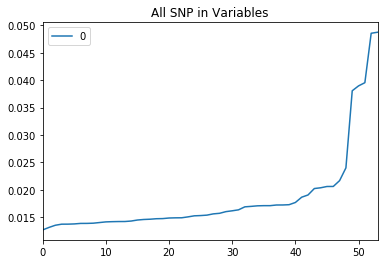

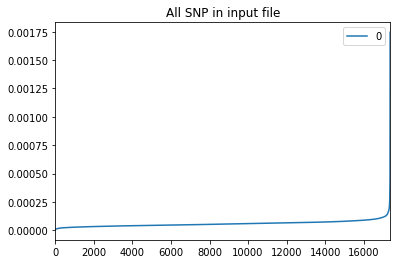

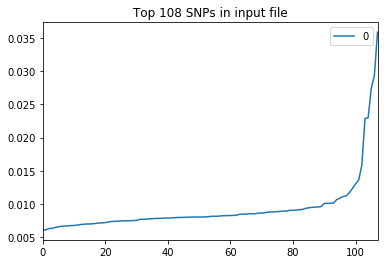

In [46]:
num_top = num_truth_snp * 2
top_snp_indexes = [snp[1] for snp in importance_indexes[:num_top]]
topSnps = snpData.iloc[:, top_snp_indexes + [-1]]
clfTop,      AucTop      = RF_AUC(topSnps, nTree=numTree)
print("AUC All SNPs in Variables : ", round(AucVar, 3))
print("AUC All SNPs in input file: ", round(Auc, 3))
print("Top " + str(num_top) + " SNPs: ", round(AucTop, 3))
pd.DataFrame(np.sort(clfVar.feature_importances_)).plot(title="All SNP in Variables")
pd.DataFrame(np.sort(clf.feature_importances_)).plot(title="All SNP in input file")
pd.DataFrame(np.sort(clfTop.feature_importances_)).plot(title="Top " + str(num_top) + " SNPs in input file")